## Import the necessary libraries

In [2]:
import keras as k
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import warnings

warnings.filterwarnings("ignore")

## Analysis of the original model

In [4]:
clean_data_path = './data/cl/valid.h5'
poisoned_data_path = './data/bd/bd_valid.h5'
model_path = './models/bd_net.h5'

def data_preparation(path):
    data = h5py.File(path, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

clean_x_test, clean_y_test = data_preparation(clean_data_path)
poisoned_x_test, posioned_y_test = data_preparation(poisoned_data_path)

posioned_model = k.models.load_model(model_path)

clean_label_p = np.argmax(posioned_model.predict(clean_x_test), axis=1)
clean_accuracy = np.mean(np.equal(clean_label_p, clean_y_test))*100
print('Clean Classification accuracy is ', clean_accuracy)

posioned_label_p = np.argmax(posioned_model.predict(poisoned_x_test), axis=1)
attack_success_rate = np.mean(np.equal(posioned_label_p, posioned_y_test))*100
print('Attack Success Rate is ', attack_success_rate)

361/361 [==============================] - 4s 12ms/step
Clean Classification accuracy is  98.64899974019225
361/361 [==============================] - 5s 13ms/step
Attack Success Rate is  100.0


In [5]:
model = k.models.load_model(model_path)

### Detailed overview of the original model

In [6]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [7]:
k.backend.clear_session()

## Model Pruning

In [8]:
# Loading the clean and poisoned data
clean_x_test, clean_y_test = data_preparation(clean_data_path)
poisoned_x_test, posioned_y_test = data_preparation(poisoned_data_path)

In [9]:
clean_data_acc = 98.64899974019225
model_duplicate = k.models.clone_model(model)
model_duplicate.set_weights(model.get_weights()) 
clean_acc = []
attack_success_rate_list = []
saved_model = np.zeros(3,dtype=bool)

# activation of the last pooling layer
layer_output=model_duplicate.get_layer('pool_3').output
intermediate_model=k.models.Model(inputs=model_duplicate.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(clean_x_test)  
seq = np.argsort(np.mean(intermediate_prediction,axis=(0,1,2)))
weight = model_duplicate.layers[5].get_weights()[0]
bias = model_duplicate.layers[5].get_weights()[1]

for idx in tqdm(seq): 
  weight[:,:,:,idx] = 0
  bias[idx] = 0
  model_duplicate.layers[5].set_weights([weight, bias])
  clean_label_p = np.argmax(model_duplicate.predict(clean_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(clean_label_p, clean_y_test))*100

  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("Saving the model at 2 percent accuracy drop")
    model_duplicate.save('acc_drop_2.h5')
    saved_model[0] = 1

  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("Saving the model at 4 percent accuracy drop")
    model_duplicate.save('acc_drop_4.h5')
    saved_model[1] = 1

  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("Saving the model at 10 percent accuracy drop")
    model_duplicate.save('acc_drop_10.h5')
    saved_model[2] = 1

  clean_acc.append(clean_accuracy)
  bad_label_p = np.argmax(model_duplicate.predict(poisoned_x_test), axis=1)
  attack_success_rate = np.mean(np.equal(bad_label_p, posioned_y_test))*100
  attack_success_rate_list.append(attack_success_rate)

  print(f"\nThe clean accuracy is {clean_accuracy}")
  print(f"The attack success rate is {attack_success_rate}")
  print(f"The pruned channel index is {idx}")
  k.backend.clear_session()


361/361 [==============================] - 4s 12ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 12ms/step


  2%|▏         | 1/60 [00:09<09:24,  9.56s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  0
361/361 [==============================] - 5s 14ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  26


  3%|▎         | 2/60 [00:20<09:52, 10.22s/it]

361/361 [==============================] - 5s 15ms/step


  5%|▌         | 3/60 [00:31<10:08, 10.67s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  27
361/361 [==============================] - 5s 13ms/step


  7%|▋         | 4/60 [00:42<10:13, 10.95s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  30
361/361 [==============================] - 5s 12ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  31


  8%|▊         | 5/60 [00:53<09:56, 10.85s/it]

361/361 [==============================] - 5s 13ms/step


 10%|█         | 6/60 [01:03<09:39, 10.73s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  33
361/361 [==============================] - 5s 14ms/step


 12%|█▏        | 7/60 [01:15<09:34, 10.84s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  34
361/361 [==============================] - 4s 12ms/step


 13%|█▎        | 8/60 [01:24<09:06, 10.51s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  36
361/361 [==============================] - 4s 12ms/step


 15%|█▌        | 9/60 [01:35<08:54, 10.47s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  37
361/361 [==============================] - 5s 14ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  38


 17%|█▋        | 10/60 [01:46<09:02, 10.85s/it]

361/361 [==============================] - 5s 14ms/step


 18%|█▊        | 11/60 [01:57<08:49, 10.80s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  25
361/361 [==============================] - 6s 16ms/step


 20%|██        | 12/60 [02:09<08:53, 11.11s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  39
361/361 [==============================] - 5s 13ms/step


 22%|██▏       | 13/60 [02:20<08:35, 10.97s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  41
361/361 [==============================] - 5s 15ms/step


 23%|██▎       | 14/60 [02:32<08:46, 11.45s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  44
361/361 [==============================] - 5s 15ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  45


 25%|██▌       | 15/60 [02:44<08:46, 11.71s/it]

361/361 [==============================] - 5s 13ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  47


 27%|██▋       | 16/60 [02:55<08:20, 11.38s/it]

361/361 [==============================] - 4s 12ms/step


 28%|██▊       | 17/60 [03:05<07:56, 11.09s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  48
361/361 [==============================] - 4s 12ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  49


 30%|███       | 18/60 [03:16<07:34, 10.83s/it]

361/361 [==============================] - 4s 12ms/step


 32%|███▏      | 19/60 [03:26<07:13, 10.57s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  50
361/361 [==============================] - 5s 13ms/step


 33%|███▎      | 20/60 [03:36<06:58, 10.46s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  53
361/361 [==============================] - 6s 15ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  55


 35%|███▌      | 21/60 [03:48<07:04, 10.88s/it]

361/361 [==============================] - 5s 13ms/step


 37%|███▋      | 22/60 [03:59<06:59, 11.04s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  40
361/361 [==============================] - 5s 15ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  24


 38%|███▊      | 23/60 [04:11<07:01, 11.39s/it]

361/361 [==============================] - 5s 15ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  59


 40%|████      | 24/60 [04:23<06:57, 11.59s/it]

361/361 [==============================] - 5s 14ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  9


 42%|████▏     | 25/60 [04:35<06:49, 11.69s/it]

361/361 [==============================] - 5s 14ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  2


 43%|████▎     | 26/60 [04:47<06:38, 11.72s/it]

361/361 [==============================] - 5s 14ms/step


 45%|████▌     | 27/60 [04:58<06:19, 11.51s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  12
361/361 [==============================] - 5s 14ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  13


 47%|████▋     | 28/60 [05:10<06:10, 11.58s/it]

361/361 [==============================] - 5s 13ms/step


 48%|████▊     | 29/60 [05:21<05:51, 11.35s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  17
361/361 [==============================] - 4s 12ms/step



 50%|█████     | 30/60 [05:31<05:31, 11.04s/it]

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  14
361/361 [==============================] - 5s 15ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  15


 52%|█████▏    | 31/60 [05:44<05:33, 11.50s/it]

361/361 [==============================] - 4s 12ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  23


 53%|█████▎    | 32/60 [05:54<05:15, 11.26s/it]

361/361 [==============================] - 5s 14ms/step


 55%|█████▌    | 33/60 [06:05<05:00, 11.12s/it]


The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  6
361/361 [==============================] - 5s 13ms/step



 57%|█████▋    | 34/60 [06:16<04:45, 10.98s/it]

The clean accuracy is  98.64033948211657
The attack success rate is  100.0
The pruned channel index is  51
361/361 [==============================] - 4s 10ms/step


 58%|█████▊    | 35/60 [06:24<04:10, 10.03s/it]


The clean accuracy is  98.64033948211657
The attack success rate is  100.0
The pruned channel index is  32
361/361 [==============================] - 4s 11ms/step


 60%|██████    | 36/60 [06:33<03:53,  9.71s/it]


The clean accuracy is  98.63167922404088
The attack success rate is  100.0
The pruned channel index is  22
361/361 [==============================] - 4s 10ms/step

The clean accuracy is  98.65765999826795
The attack success rate is  100.0
The pruned channel index is  21


 62%|██████▏   | 37/60 [06:41<03:34,  9.32s/it]

361/361 [==============================] - 4s 11ms/step

The clean accuracy is  98.64899974019225
The attack success rate is  100.0
The pruned channel index is  20


 63%|██████▎   | 38/60 [06:49<03:19,  9.07s/it]

361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:58<03:06,  8.86s/it]


The clean accuracy is  98.6056984498138
The attack success rate is  100.0
The pruned channel index is  19
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [07:06<02:54,  8.72s/it]


The clean accuracy is  98.57105741751104
The attack success rate is  100.0
The pruned channel index is  43
361/361 [==============================] - 4s 10ms/step


 68%|██████▊   | 41/60 [07:15<02:44,  8.65s/it]


The clean accuracy is  98.53641638520828
The attack success rate is  100.0
The pruned channel index is  58
361/361 [==============================] - 3s 9ms/step


 70%|███████   | 42/60 [07:24<02:39,  8.84s/it]


The clean accuracy is  98.19000606218066
The attack success rate is  100.0
The pruned channel index is  3
361/361 [==============================] - 4s 10ms/step


 72%|███████▏  | 43/60 [07:33<02:29,  8.79s/it]


The clean accuracy is  97.65307006148784
The attack success rate is  100.0
The pruned channel index is  42
361/361 [==============================] - 4s 11ms/step

The clean accuracy is  97.50584567420108
The attack success rate is  100.0
The pruned channel index is  1


 73%|███████▎  | 44/60 [07:41<02:20,  8.79s/it]

361/361 [==============================] - 4s 10ms/step
Saving the model at 2 percent accuracy drop
361/361 [==============================] - 4s 12ms/step


 75%|███████▌  | 45/60 [07:51<02:13,  8.89s/it]


The clean accuracy is  95.75647354291158
The attack success rate is  100.0
The pruned channel index is  29
361/361 [==============================] - 4s 10ms/step

The clean accuracy is  95.20221702606739
The attack success rate is  99.9913397419243
The pruned channel index is  16


 77%|███████▋  | 46/60 [07:59<02:02,  8.76s/it]

361/361 [==============================] - 4s 10ms/step

The clean accuracy is  94.7172425738287
The attack success rate is  99.9913397419243
The pruned channel index is  56


 78%|███████▊  | 47/60 [08:07<01:51,  8.61s/it]

361/361 [==============================] - 4s 12ms/step
Saving the model at 4 percent accuracy drop
361/361 [==============================] - 4s 11ms/step


 80%|████████  | 48/60 [08:18<01:49,  9.12s/it]


The clean accuracy is  92.09318437689443
The attack success rate is  99.9913397419243
The pruned channel index is  46
361/361 [==============================] - 4s 11ms/step


 82%|████████▏ | 49/60 [08:26<01:39,  9.01s/it]


The clean accuracy is  91.49562656967177
The attack success rate is  99.9913397419243
The pruned channel index is  5
361/361 [==============================] - 4s 11ms/step

The clean accuracy is  91.01931237550879
The attack success rate is  99.98267948384861
The pruned channel index is  8


 83%|████████▎ | 50/60 [08:35<01:30,  9.04s/it]

361/361 [==============================] - 4s 10ms/step


 85%|████████▌ | 51/60 [08:44<01:19,  8.82s/it]


The clean accuracy is  89.17467740538669
The attack success rate is  80.73958603966398
The pruned channel index is  11
361/361 [==============================] - 4s 12ms/step
Saving the model at 10 percent accuracy drop
361/361 [==============================] - 4s 11ms/step


 87%|████████▋ | 52/60 [08:55<01:15,  9.41s/it]


The clean accuracy is  84.43751623798389
The attack success rate is  77.015675067117
The pruned channel index is  54
361/361 [==============================] - 4s 10ms/step


 88%|████████▊ | 53/60 [09:02<01:02,  8.97s/it]


The clean accuracy is  76.48739932449988
The attack success rate is  35.71490430414826
The pruned channel index is  10
361/361 [==============================] - 4s 10ms/step


 90%|█████████ | 54/60 [09:11<00:53,  8.95s/it]


The clean accuracy is  54.8627349095003
The attack success rate is  6.954187234779596
The pruned channel index is  28
361/361 [==============================] - 4s 12ms/step


 92%|█████████▏| 55/60 [09:21<00:45,  9.12s/it]


The clean accuracy is  27.08928726076037
The attack success rate is  0.4243526457088421
The pruned channel index is  35
361/361 [==============================] - 4s 12ms/step


 93%|█████████▎| 56/60 [09:32<00:38,  9.67s/it]


The clean accuracy is  13.87373343725643
The attack success rate is  0.0
The pruned channel index is  18
361/361 [==============================] - 4s 11ms/step

The clean accuracy is  7.101411622066338
The attack success rate is  0.0
The pruned channel index is  4


 95%|█████████▌| 57/60 [09:41<00:28,  9.57s/it]

361/361 [==============================] - 4s 11ms/step

The clean accuracy is  1.5501861955486274
The attack success rate is  0.0
The pruned channel index is  7


 97%|█████████▋| 58/60 [09:50<00:18,  9.44s/it]

361/361 [==============================] - 4s 11ms/step

The clean accuracy is  0.7188014202823244
The attack success rate is  0.0
The pruned channel index is  52


 98%|█████████▊| 59/60 [09:59<00:09,  9.35s/it]

361/361 [==============================] - 4s 11ms/step


100%|██████████| 60/60 [10:09<00:00, 10.15s/it]


The clean accuracy is  0.0779423226812159
The attack success rate is  0.0
The pruned channel index is  57


### Visualizing the accuracy and attack success rates

Text(0.5, 1.0, 'Clean Accuracy and Attack Success Rate on Validation Data')

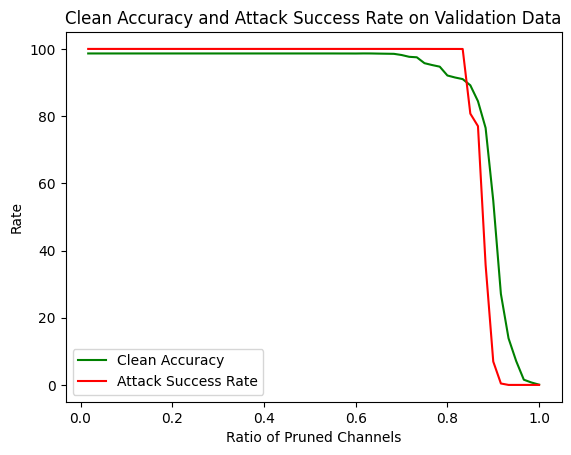

In [14]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc, color='green')
plt.plot(x_axis,attack_success_rate_list, color='red')
plt.legend(['Clean Accuracy','Attack Success Rate'])
plt.xlabel("Ratio of Pruned Channels")
plt.ylabel("Rate")
plt.title("Clean Accuracy and Attack Success Rate on Validation Data")

In [11]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print(f"The attack success rate at the accuracy drop of 30 percent is {attack_success_rate_list[index[0]]}")

The attack success rate at the accuracy drop of 30 percent is 6.954187234779596


## Merging the models

In [12]:
class G(k.Model):
  def __init__(self, B, B_dash):
      super(G, self).__init__()
      self.B = B
      self.B_dash = B_dash

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_dash(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluating the merged model

In [13]:
test_data_path = './data/cl/test.h5'
poisoned_test_data_path = './data/bd/bd_test.h5'
test_acc_drop_2_path = './acc_drop_2.h5'
test_acc_drop_4_path = './acc_drop_4.h5'
test_acc_drop_10_path = './acc_drop_10.h5'

In [15]:
test_acc_drop_2 = k.models.load_model(test_acc_drop_2_path)
test_acc_drop_4 = k.models.load_model(test_acc_drop_4_path)
test_acc_drop_10 = k.models.load_model(test_acc_drop_10_path)

In [16]:
x_test_data, y_test_data = data_preparation(test_data_path)
x_test_poisoned_data, y_test_poisnoed_data = data_preparation(poisoned_test_data_path)

In [17]:
G_acc_drop_2 = G(model, test_acc_drop_2)
G_acc_drop_4 = G(model, test_acc_drop_4)
G_acc_drop_10 = G(model, test_acc_drop_10)

### Model evaluation

In [19]:
cl_test_2_label_p = np.argmax(test_acc_drop_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print(f"2% drops model, the clean test data Classification accuracy: {clean_test_2_accuracy}")

bd_test_2_label_p = np.argmax(test_acc_drop_2.predict(x_test_poisoned_data), axis=1)
attack_success_rate_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print(f"2% drops model, Attack Success Rate: {attack_success_rate_2}")

cl_test_4_label_p = np.argmax(test_acc_drop_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print(f"4% drops model, the clean test data classification accuracy: {clean_test_4_accuracy}")

bd_test_4_label_p = np.argmax(test_acc_drop_4.predict(x_test_poisoned_data), axis=1)
attack_success_rate_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print(f"4% drops model, Attack Success Rate: {attack_success_rate_4}")

cl_test_10_label_p = np.argmax(test_acc_drop_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print(f"10% drops model, the clean test data classification accuracy: {clean_test_10_accuracy}")

bd_test_10_label_p = np.argmax(test_acc_drop_10.predict(x_test_poisoned_data), axis=1)
attack_success_rate_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print(f"10% drops model, Attack Success Rate: {attack_success_rate_10}")

401/401 [==============================] - 4s 9ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 3s 8ms/step
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 3s 8ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 3s 8ms/step
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 3s 8ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 4s 10ms/step
10% drops model, Attack Success Rate: 77.20966484801247


### Metrics for the repaired models

In [20]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [attack_success_rate_2, attack_success_rate_4, attack_success_rate_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


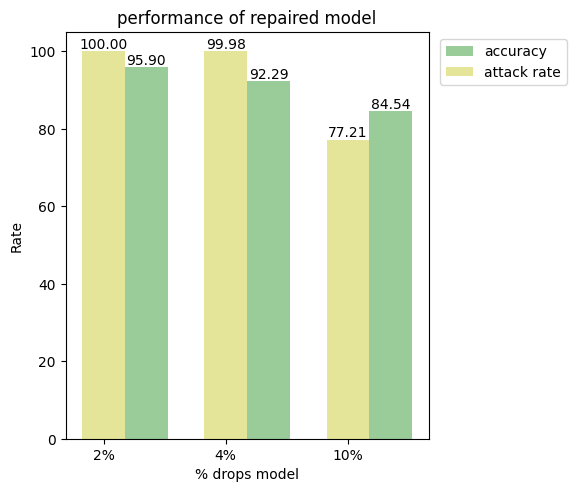

In [21]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='g', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='y', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
plt.show()

### Evaluating the performance of the GoodNet

In [22]:
G_cl_test_2_label_p = G_acc_drop_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print(f'Combined 2% drops model, the clean test data Classification accuracy: {G_clean_test_2_accuracy}')

G_bd_test_2_label_p = G_acc_drop_2.predict(x_test_poisoned_data)
G_attack_success_rate_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print(f'Combined 2% drops model, Attack Success Rate: {G_attack_success_rate_2}')

G_cl_test_4_label_p = G_acc_drop_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print(f'Combined 4% drops model, the clean test data Classification accuracy: {G_clean_test_4_accuracy}')

G_bd_test_4_label_p = G_acc_drop_4.predict(x_test_poisoned_data)
G_attack_success_rate_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print(f'Combined 4% drops model, Attack Success Rate: {G_attack_success_rate_4}')

G_cl_test_10_label_p = G_acc_drop_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print(f'Combined 10% drops model, the clean test data Classification accuracy: {G_clean_test_10_accuracy}')

G_bd_test_10_label_p = G_acc_drop_10.predict(x_test_poisoned_data)
G_attack_success_rate_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print(f'Combined 10% drops model, Attack Success Rate: {G_attack_success_rate_10}')

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [23]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_attack_success_rate_2, G_attack_success_rate_4, G_attack_success_rate_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


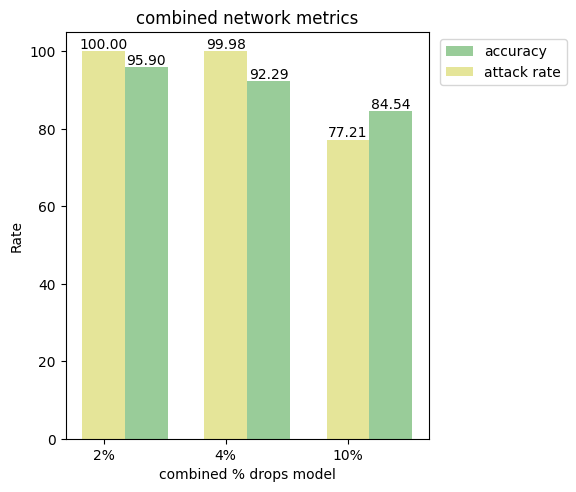

In [28]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='g', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='y', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('combined network metrics')
plt.show()